# Multivariate time-series analysis with Explainable Boosting Machine (EBM)

Explainable Boosting Machine (EBM) is an interpretable machine learning model that combines the advantages of Generalized Additive Models (GAMs) and gradient boosting . EBM uses techniques like bagging, automatic interaction detection, and cyclic coordinate descent to improve the accuracy and interpretability of GAMs . EBM is developed at Microsoft Research and is included in the InterpretML framework

Data preprocessing:
1. Categorical features have been Encoded
2. Text columns and columns that have no effect on the model have been dropped
3. Added 7 lagged values

Model trainig:
1. Trained a EBM model using RandomizedSearch and then GridSearchCV

Results:

1. Model performance
- MAE: 38.72
- MSE: 2726.38
- MAPE: 0.056
- RMSE: 52.21
- R2: 0.341
2. Explain how the model generates prediction

## Import modules

In [1]:
!pip install interpret --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from interpret.glassbox import ExplainableBoostingRegressor
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,  mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import pickle

import warnings
warnings.filterwarnings('ignore')

seed = 42

## Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
w_encoding_file = '/content/drive/MyDrive/Omdena/Houston Local Chapter/Weather&Crime/Data/Cleaned data/encoding_weather_by_dihia_Lanasri.csv'
filename = '/content/drive/MyDrive/Omdena/Houston Local Chapter/Weather&Crime/Data/Cleaned data/daily crime numbers and weather data for time series analysis.csv'

In [5]:
df = pd.read_csv(filename, parse_dates=['date'])
df.shape

(4960, 74)

In [6]:
df.head()

,date,Kidnapping/Abduction,"Sex Offenses, Forcible",Robbery,Assault Offenses,Arson,Extortion/Blackmail,Burglary/Breaking & Entering,Larceny/Theft Offenses,Motor Vehicle Theft,...,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2010-01-01,0,13,31,58,0,0,77,215,21,...,174.8,15.0,7.0,07:16:59,17:33:24,0.53,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KHOU,72059400188,KIAH,KMCJ,72244012918,7224301..."
1,2010-01-02,0,2,32,15,0,0,67,200,28,...,156.6,13.4,6.0,07:17:13,17:34:07,0.57,Clear,Clear conditions throughout the day.,clear-day,"KHOU,72059400188,KIAH,KMCJ,72244012918,7224301..."
2,2010-01-03,0,0,38,35,0,0,52,179,35,...,80.2,6.7,3.0,07:17:25,17:34:50,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KHOU,72059400188,KIAH,KMCJ,72244012918,7224301..."
3,2010-01-04,0,1,24,25,0,0,94,211,29,...,167.4,14.5,7.0,07:17:35,17:35:35,0.64,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KHOU,72059400188,KIAH,KMCJ,72244012918,7224301..."
4,2010-01-05,0,3,19,22,0,0,88,183,20,...,174.1,15.0,7.0,07:17:44,17:36:20,0.67,Clear,Clear conditions throughout the day.,clear-day,"KHOU,72059400188,KIAH,KMCJ,72244012918,7224301..."


In [7]:
w_encoding_df = pd.read_csv(w_encoding_file)

In [8]:
# the column 'conditions' has been encoded to five columns, concatenate weather_encoding_data
df = pd.concat([df, w_encoding_df.loc[:,['Clear', 'Overcast', 'Partiallycloudy', 'Rain', 'Snow']]], axis=1).drop(columns='conditions')

In [9]:
df = df.iloc[0:4960]

In [10]:
df.set_index('date', inplace=True)

## Target variables: total daily crime number `Offense Count` and numbers of top 6 crime types

In [11]:
targets_df = df.loc[:,'Kidnapping/Abduction':'Offense Count']
targets_columns = targets_df.sum().T.sort_values(ascending=False).head(7).index

## Feature engineering

In [12]:
# null values
counts = df.isnull().sum()
print(counts.sort_values(ascending=False))

solarradiation                          365
solarenergy                             365
uvindex                                 365
Kidnapping/Abduction                      0
snowdepth                                 0
                                       ... 
Curfew/Loitering/Vagrancy Violations      0
Bad Checks                                0
Homicide Offenses                         0
Animal Cruelty                            0
Snow                                      0
Length: 77, dtype: int64


A full year (2014) worth of data is missing for solarenergy, solarradiation, and uvindex

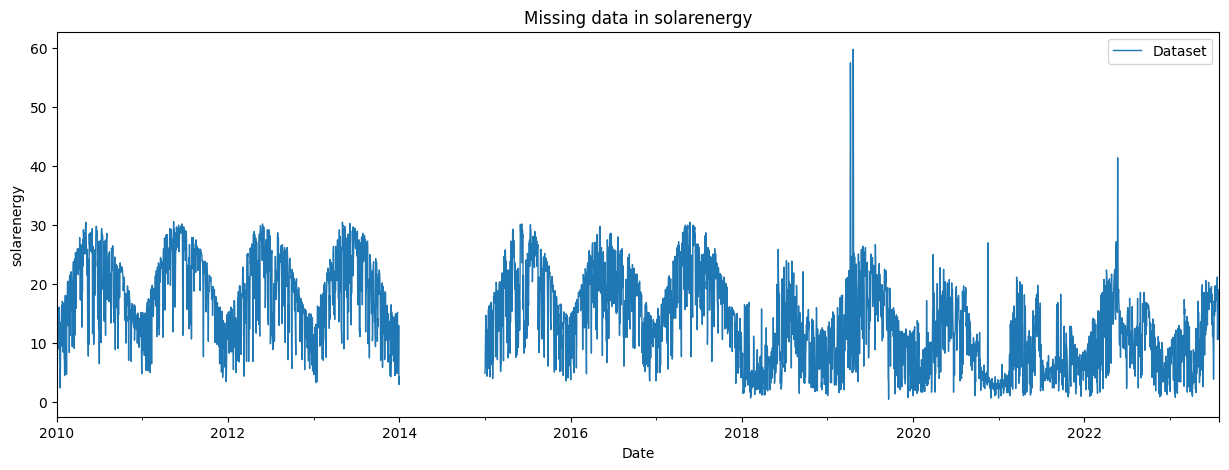

In [13]:
#Visualizing missing solarenergy values
fig, ax = plt.subplots(figsize=(15, 5))

df.plot(y='solarenergy', ax=ax, label='Dataset', title='Missing data in solarenergy', linewidth=1)

plt.xlabel("Date")
plt.ylabel("solarenergy")
plt.show()

In [14]:
# Fill missing data with values from the previous year
df = df.fillna(df.shift(365))

In [15]:
# using sunrise and sunset to create daytime
# Convert them to datetime format
df['sunset'] = pd.to_datetime(df['sunset'], format='%H:%M:%S')
df['sunrise'] = pd.to_datetime(df['sunrise'], format='%H:%M:%S')

# Calculate the time difference between 'sunset' and 'sunrise'
# and extract the daytime interval in seconds for numerical analysis
df['daytime_interval'] = (df['sunset'] - df['sunrise']).dt.total_seconds()


Time series are characterized by the time-related dependenceies between values. To make use of this aspect in our model we will integrate a number of past values of the target variable as input features. We use 7 of the most recent past values as this captures most of the past data information.

In [16]:
def create_lag_features(df, column_name, lags=7):
  y = df.loc[:, column_name]
  for lag in range(lags):
    df[f"lag_{lag + 1}_{column_name}"] = y.shift(lag + 1)
  return df

for column in ['Offense Count']:
  df = create_lag_features(df, column,lags=7)


Check collinearity features `solarenergy`. Drop it in the pipe.

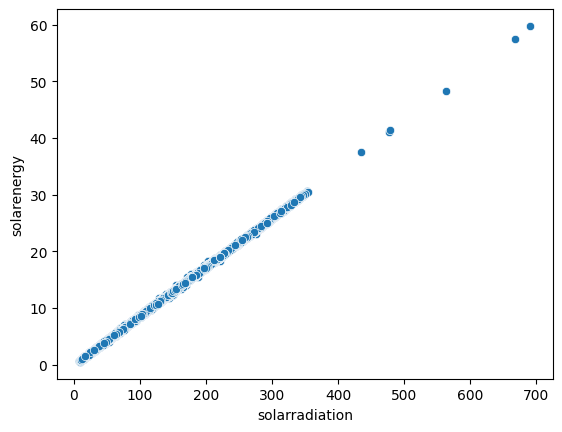

In [17]:
sns.scatterplot(data=df, x='solarradiation',y='solarenergy');

In [18]:
# some weather features to drop
print(df['precipprob'].unique())
print(df['snow'].unique())
print(df['snowdepth'].unique())
print(df['icon'].unique())

[  0. 100.]
[0.  0.2]
[0.  0.1 0.7 2.3 0.2]
['partly-cloudy-day' 'clear-day' 'rain' 'cloudy' 'wind' 'snow']


- Encode categorical data
- Drop text columns and columns that have no impact on the model

In [19]:
# "OneHotEncode" categorial fetures
def encodeCategoricalFeatures(main_df):
    df = main_df.copy()

    columns = ["week", "season"] # "icon",  "preciptype"

    dummies = pd.get_dummies(df[columns])
    df = pd.concat([df, dummies], axis='columns')

    return df

# drop cols
def dropFeatures(main_df):
    df = main_df.copy()
    df.drop(df.loc[:, :'Offense Count'], axis=1, inplace=True)
    cols = [
        'week',
        'season',
        'icon',
        'mon_year',
        'preciptype',
        'sunrise',
        'sunset',
        'solarenergy',
        'description',
        'stations',
        'snow',
        'snowdepth',
        'precipprob',
    ]
    df.drop(columns=cols, inplace=True)
    return df

In [20]:
df = (df
      .pipe(encodeCategoricalFeatures)
      .pipe(dropFeatures)
)

## Model development
### Train / test split

In [21]:
def prepare_data(df=df, column_name= 'Offense Count'):
  df = df.merge( targets_df[column_name], left_index=True, right_index=True)
  return df

In [22]:
df_all = prepare_data()
df_all.head().T

date,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05
month,1.00,1.00,1.0,1.00,1.00
year,2010.00,2010.00,2010.0,2010.00,2010.00
is_holiday,1.00,0.00,0.0,0.00,0.00
is_weekend,0.00,1.00,1.0,0.00,0.00
tempmax,53.90,53.70,47.4,46.40,48.20
tempmin,41.30,40.10,41.1,36.20,31.70
temp,46.90,46.30,44.8,41.80,38.70
feelslikemax,53.90,53.70,46.5,42.10,47.50
feelslikemin,33.00,34.90,33.8,28.70,24.00
feelslike,42.30,43.10,40.8,35.20,34.30


In [23]:
# Split df_final into train and test
df_all.dropna(inplace=True)
num_train = int(len(df_all)*0.8)
train = df_all[:num_train]
test = df_all[num_train:]

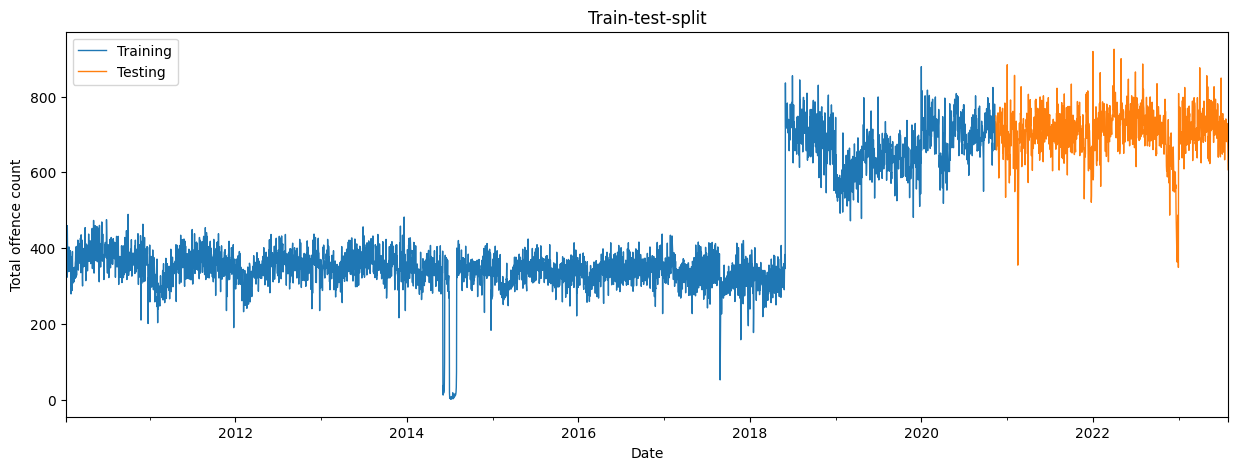

In [24]:
figure, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training", y="Offense Count", linewidth=1)
test.plot(ax=ax, label="Testing", y="Offense Count", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Total offence count")
plt.title('Train-test-split')
plt.show()

In [25]:
X_train = train.drop('Offense Count', axis=1) #.values
y_train = train['Offense Count'] #.values

X_test = test.drop('Offense Count', axis=1) # .values
y_test = test['Offense Count'] # .values

### EBM

#### Hyperparameter tuning

In [65]:
# Use Randomized Search to locate the approximate hyperparameters
ebm = ExplainableBoostingRegressor(random_state=seed)
param_grid = {
    'learning_rate': np.linspace(0.05,0.7,14),
    'min_samples_leaf': list(range(3,9)),
    "max_leaves": list(range(2,12))
    }
random_ebm = RandomizedSearchCV(
    estimator=ebm,
    param_distributions=param_grid,
    n_iter=60,
    n_jobs=-1,
    cv=cv_split,
    return_train_score=True)
random_ebm.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
                   estimator=ExplainableBoostingRegressor(), n_iter=60,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 ]),
                                        'max_leaves': [2, 3, 4, 5, 6, 7, 8, 9,
                                                       10, 11],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8]},
                   return_train_score=True)

In [66]:
best_params_rn = random_ebm.best_params_
print(best_params_rn)

{'min_samples_leaf': 3, 'max_leaves': 2, 'learning_rate': 0.49999999999999994}


In [71]:
# Grid Search after randomized search locating

cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
ebm = ExplainableBoostingRegressor(random_state=seed)
parameters = {
    "min_samples_leaf": [3,4,5], #3
    "max_leaves": [2], #2
    "learning_rate": np.linspace(0.05,0.5,19) #0.05
}

grid_search = GridSearchCV(estimator=ebm, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=ExplainableBoostingRegressor(),
             param_grid={'learning_rate': array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 ,
       0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 , 0.475,
       0.5  ]),
                         'max_leaves': [2], 'min_samples_leaf': [3, 4, 5]})

In [110]:
best_params = grid_search.best_params_
print(best_params)

{'learning_rate': 0.05, 'max_leaves': 2, 'min_samples_leaf': 3}


In [26]:
best_params = {'learning_rate': 0.05, 'max_leaves': 2, 'min_samples_leaf': 3}

In [27]:
ebm = ExplainableBoostingRegressor(random_state=seed)
ebm.set_params(**best_params)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(learning_rate=0.05, max_leaves=2,
                             min_samples_leaf=3)

#### Explain the Glassbox

Glassbox models can provide explanations on a both global (overall behavior) and local (individual predictions) level.

Global explanations are useful for understanding what a model finds important, as well as identifying potential flaws in its decision making (i.e. racial bias).

In [28]:
show(ebm.explain_global())

Output hidden; open in https://colab.research.google.com to view.

Local explanations show how a single prediction is made. For glassbox models, these explanations are exact – they perfectly describe how the model made its decision.

These explanations are useful for describing to end users which factors were most influential for a prediction.

#### Evaluation

In [32]:
def evaluate_model(y_test, pred):
  print(f"MAE: {mean_absolute_error(y_test, pred)}")
  print(f"MSE: {mean_squared_error(y_test, pred)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, pred)}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
  print(f"R2: {r2_score(y_test,pred)}")

def plot_predictions(model_name, testing_dates, y_test, pred, target=y_test.name):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": pred })
  figure, ax = plt.subplots(figsize=(15, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction", linewidth=2)
  plt.legend(["Actual", "Prediction"], loc='best')
  plt.title(target + " ("+model_name+")")
  plt.show()

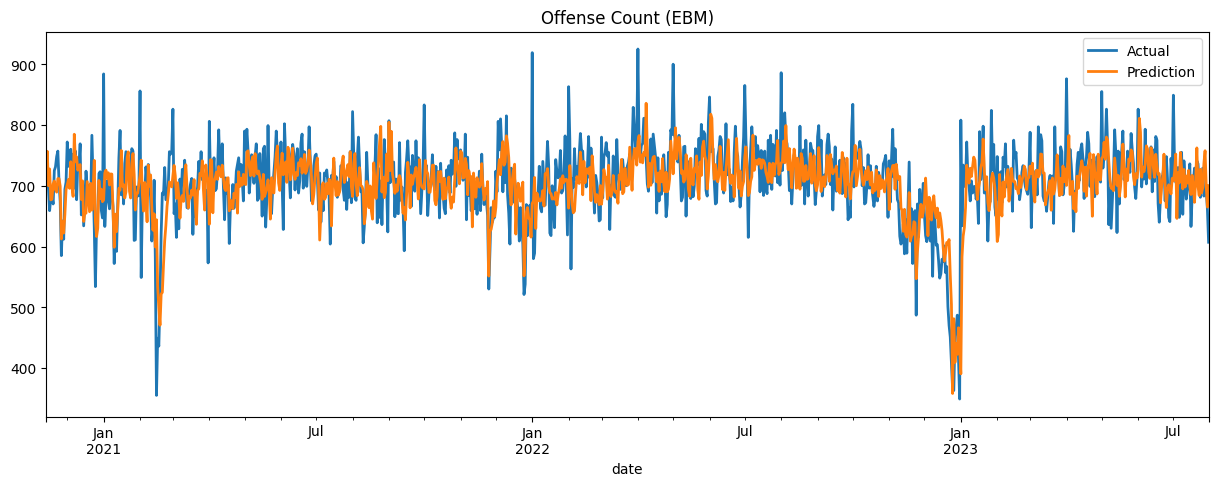

MAE: 38.72724061713555
MSE: 2726.3796942650024
MAPE: 0.05591856499824589
RMSE: 52.214745946571476
R2: 0.34093366038765405


In [33]:
# Evaluating GridSearch results
pred = ebm.predict(X_test)
plot_predictions("EBM", test.index, y_test, pred)
evaluate_model(y_test, pred)

###  Fit top 6 daily specific crime count and explain the model

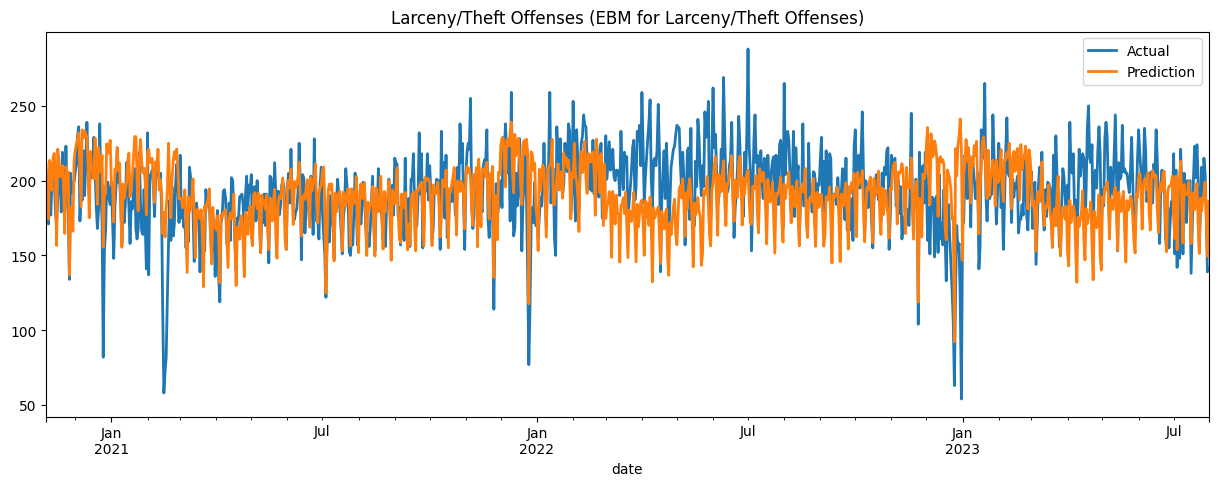

MAE: 20.672111187869568
MSE: 746.952970458085
MAPE: 0.11487560913222249
RMSE: 27.330440363413192
R2: -0.01286742151075071


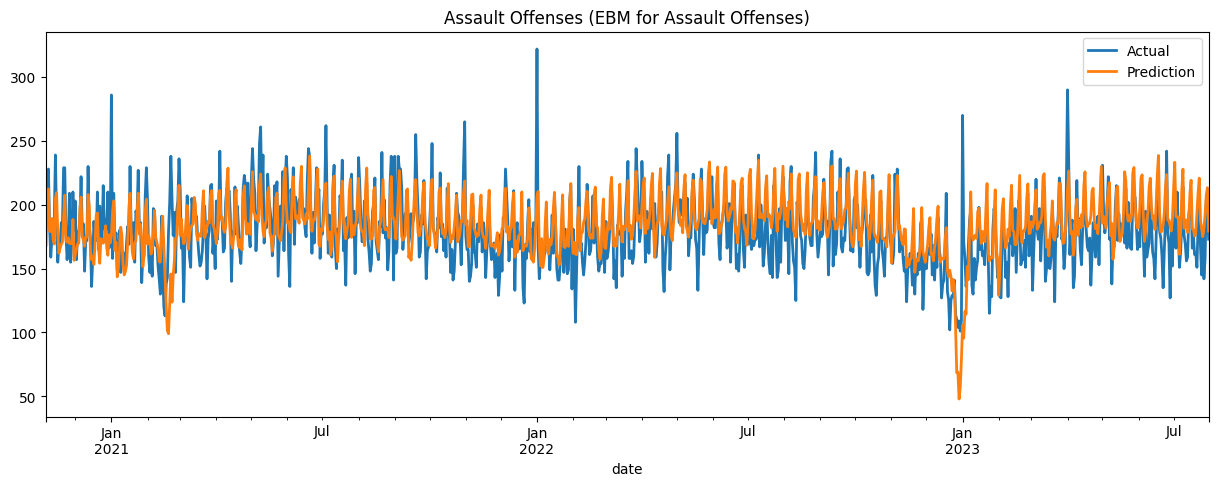

MAE: 18.151915473038564
MSE: 556.6384228199822
MAPE: 0.10626081587717053
RMSE: 23.5931859404359
R2: 0.29201207483776204


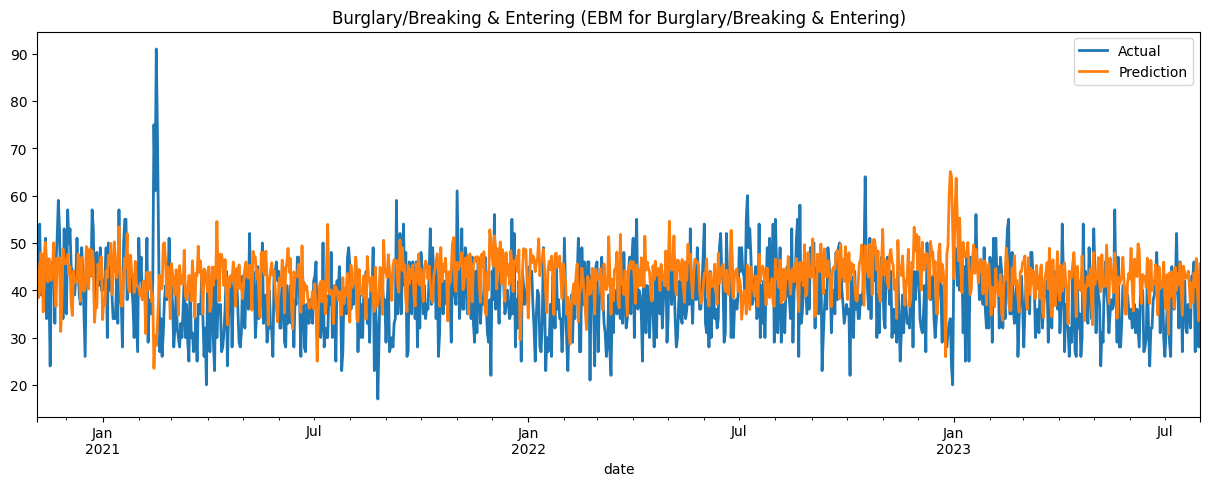

MAE: 7.48284312174176
MSE: 91.32276789017706
MAPE: 0.21730123804580168
RMSE: 9.556294673678552
R2: -0.4995163402638907


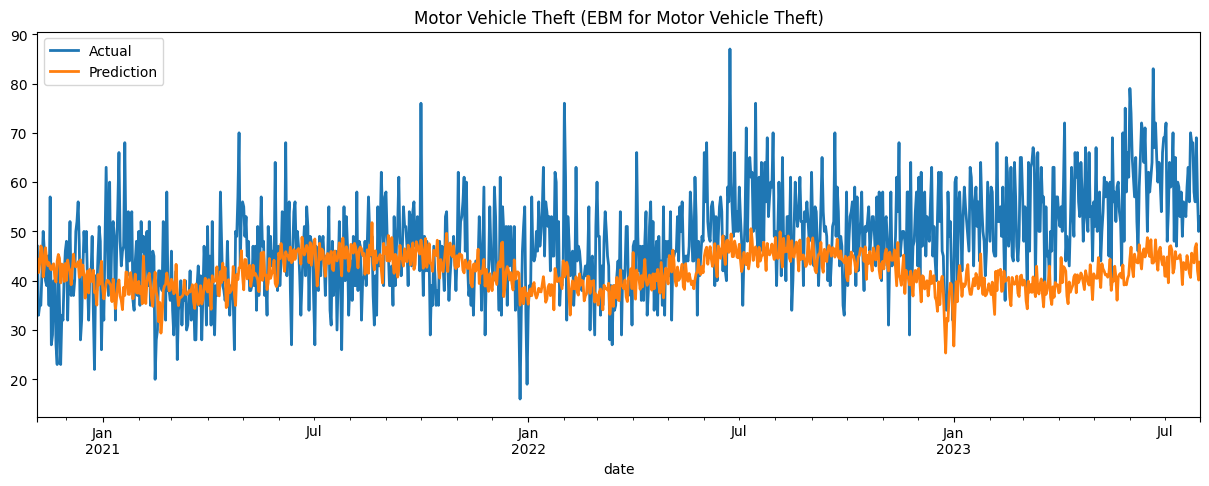

MAE: 9.348591959911937
MSE: 139.78016948015377
MAPE: 0.1871479763672018
RMSE: 11.822866381726293
R2: -0.36608767168108614


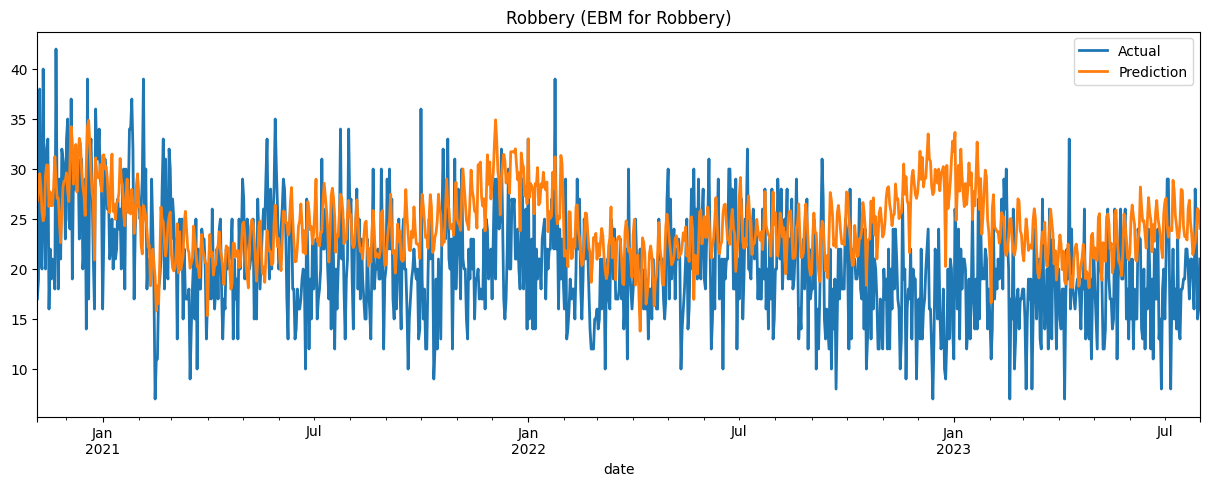

MAE: 5.73805472522745
MSE: 49.515523376411714
MAPE: 0.3494864724772397
RMSE: 7.0367267515807175
R2: -0.582437477677719


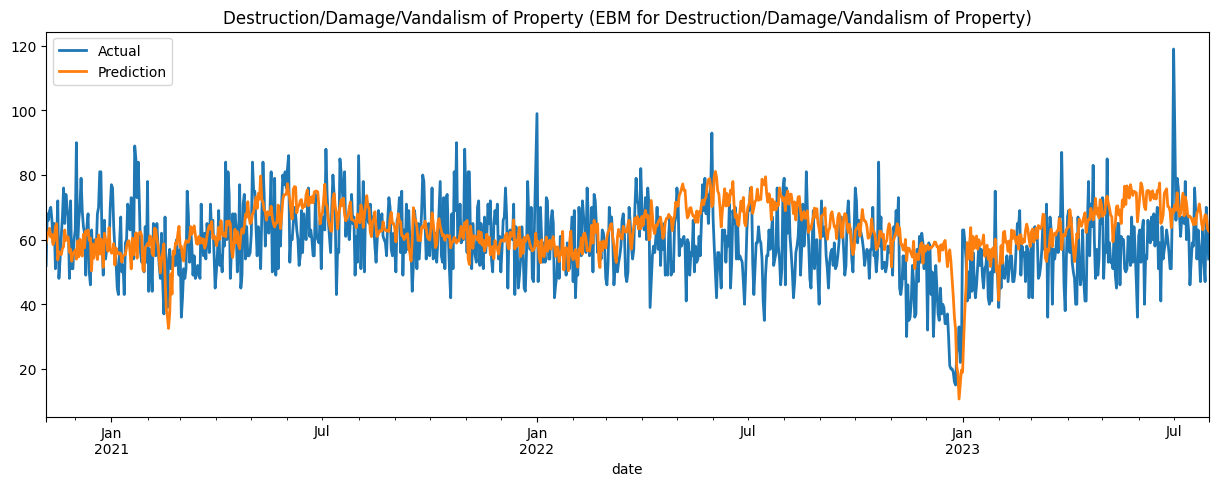

MAE: 9.78203923052218
MSE: 151.14265806673473
MAPE: 0.18511582286901415
RMSE: 12.294009031505334
R2: -0.16758887525474941


In [35]:
# a dictionary to save model objects
ebm_specific = {}

# iterate over top 6 crime types
for column in targets_columns[1:]:
  # prepare data for model training
  specific_df = prepare_data( column_name= column)

  # train-test-split
  train = specific_df[:num_train]
  test = specific_df[num_train:]
  X_train = train.drop(column, axis=1)
  y_train = train[column]
  X_test = test.drop(column, axis=1)
  y_test = test[column]

  #model training
  ebm_sc = ExplainableBoostingRegressor(random_state=seed)
  ebm_sc.fit(X_train, y_train)
  ebm_specific[column] = ebm_sc

  # Evaluating model results
  pred = ebm_sc.predict(X_test)
  plot_predictions("EBM" + " for "+ column, test.index, y_test, pred, target=column)
  evaluate_model(y_test, pred)

The model for Assault Offenses can explains part of the variance ratio of test date with R^2 of 0.29. The mean absolute error are about 10%. Explain the model below.

#### Explain Assault Offenses model

In [37]:
ebm_ao = ExplainableBoostingRegressor(random_state=seed)
specific_df = prepare_data( column_name= 'Assault Offenses')
ebm_ao.fit(specific_df.drop('Assault Offenses', axis=1), specific_df['Assault Offenses'])
show(ebm_ao.explain_global())

## Retrain a model with the best parameters and all data

In [39]:
ebm_final = ExplainableBoostingRegressor(random_state=seed)
ebm_final.set_params(**best_params)
ebm_final.fit(df_all.drop('Offense Count', axis=1),df_all['Offense Count'])

ExplainableBoostingRegressor(learning_rate=0.05, max_leaves=2,
                             min_samples_leaf=3)

In [40]:
path = '/content/drive/MyDrive/Omdena/Houston Local Chapter/Weather&Crime/Models/'

# Save the model and deploy next
with open(path + 'ebm.pkl', 'wb') as f:
    pickle.dump(ebm_final, f)

with open(path + 'ebm_Assault_Offenses.pkl', 'wb') as f:
    pickle.dump(ebm_ao, f)

# # Load the model
# with open('model.pkl', 'rb') as f:
#     ebm = pickle.load(f)